I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_file = '/u/ki/swmclau2/des/xi_cosmo_trainer/PearceRedMagicXiCosmoFixedNd.hdf5'
test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [4]:
a = 1.0
z = 1.0/a - 1.0

In [5]:
fixed_params = {'z':z, 'r':24.06822623}

In [6]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params,\
                     custom_mean_function = 'linear', downsample_factor=0.5)#,
                    #hyperparams = {'n_estimators': 500,
                    #              'max_depth': 5})

In [7]:
emu.x.shape

(40000, 11)

In [8]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM0',
 'sigma_logM',
 'logM1',
 'alpha']

In [9]:
zhongzhu_dict = {'omch2':[0.2661017,1.8339794 ], 'ombh2':[0.1054246,10.6161248], 'ln10As':[1.1295944,2.2441632],\
                 'H0':[0.3643993,13.8155106],\
                'ns':[0.2408568,10.6371797], 'Neff':[11.5649985,11.3512804], 'w0':[5.6407612,7.342365 ],\
                 'logM0': [4.9071932,3.1795786,],\
                 'alpha':[10.6279446,3.7658774], 'logM1':[11.7621938,5.0188608], 'sigma_logM':[4.7031938, 4.6846614], 'logMmin':[1.0, 1.0],
                'amp':[-12.0550382, 0.0], 'r':[0.0, 0.0]}

names = ['amp']
names.extend(emu.get_param_names())
from itertools import cycle
names = cycle(names)
amp_count = 0
v = [-1.5383083]
for n in names:
    if n== 'amp':
        amp_count+=1
    if amp_count==3:
        break
    if n in zhongzhu_dict:
        v.append(zhongzhu_dict[n][amp_count-1]) #this is a poison hack dont judge me
    else:
        v.append(1.0)
    #v.append(zhongzhu_dict[n][amp_count]) #this is a poison hack dont judge me


        
v = np.array(v)

In [16]:
#Bayesian Optimization Fit
v = [-2.30321746, -6.,          2.74986581, -0.59132415,  0.74564814, -1.47243557,
  5.38958859,  2.36982126,  5.35110678,  1.6798139,   6.,          2.82272942,
  6.        ]

#[ 6.         -6.         -2.95890662 -6.         -3.63039154  6.
# -0.93930637 -6.         -6.          2.2162459   6.          2.75175138
#  5.09211467]


In [17]:
emu._emulator.set_parameter_vector(v)
#for _emulator in emu._emulators:
#    _emulator.set_parameter_vector(v)

In [18]:
gof = emu.goodness_of_fit(training_file, N = 1000, statistic = 'log_frac')
print gof.mean()

0.000851780841296


In [19]:
gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print gof.mean(), np.median(gof)

0.0348161431318 0.0327549694599


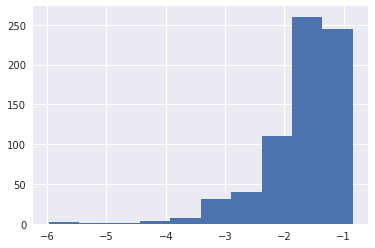

In [20]:
plt.hist(np.log10(gof) );

In [ ]:
emu.x.shape

In [ ]:
n_cosmo_params = 7
loo_cosmo = emu.x[0, 0,  :n_cosmo_params]

loo_cosmo_idxs = np.all(emu.x[:, :,:n_cosmo_params] == loo_cosmo, axis =2)
train_x, train_y, train_yerr = emu.x[~loo_cosmo_idxs, :], emu.y[ ~loo_cosmo_idxs], emu.yerr[ ~loo_cosmo_idxs]
test_x, test_y, test_yerr = emu.x[loo_cosmo_idxs, :], emu.y[loo_cosmo_idxs], emu.yerr[loo_cosmo_idxs]

In [ ]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [ ]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean


In [ ]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

In [ ]:
resids = np.abs(emu.y*emu._y_std+emu._y_mean - ypred)

In [ ]:
np.mean(resids/(emu.y*emu._y_std+emu._y_mean))

In [ ]:
ypred.mean(), emu._y_mean

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print test_gof.mean()

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'frac')
print test_gof.mean()

In [ ]:
plt.hist(np.log10(test_gof));

In [ ]:
test_x

In [ ]:
(emu.x*emu._x_std) + emu._x_mean

In [ ]:
emu.get_param_names()

In [ ]:
test_x_white, test_y_white = (test_x - emu._x_mean)/(emu._x_std + 1e-5), (test_y - emu._y_mean)/(emu._y_std + 1e-5)

In [ ]:
model = emu._emulator

In [ ]:
pred_y_white = model.predict(emu.y, test_x_white, False, False, False)

In [ ]:
pred_y = pred_y_white*emu._y_std + emu._y_mean

In [ ]:
plt.plot(pred_y[:100], label = 'pred')
plt.plot(test_y[:100], label = 'truth')

plt.legend(loc = 'best')

In [ ]:
test_y.mean(), emu._y_mean, pred_y.mean()

In [ ]:
test_y.std(), emu._y_std, pred_y.std()

In [ ]:
plt.hist(pred_y_white, bins = np.linspace(-3, 3, 100), label = 'Pred')
plt.hist(test_y_white, bins = np.linspace(-3, 3, 100), label = 'Test', alpha = 0.4);
plt.legend(loc = 'best')